In this demonstration, we consider the following 1-D Gaussian mixture density function:
$$
f(x) \propto 0.5 \exp \left( \frac{(q-1)^2}{2 \times 0.35^2} \right) + 0.5 \exp \left( \frac{(q+1)^2}{2 \times 0.35^2}\right),
$$
where the right hand side is considered as the function of exponentialized negative potential energy $\exp (-U(q))$. The kinetic energy is selected as 

In [1]:
import sys
sys.path.append('../')
from hamilton_neural_network import (
    TrainTestData,
    HamiltonianNeuralNetwork,
    LatentHamiltonianNeuralNetwork,
)
from hamilton_system import HamiltonianSystem
from pdf_models import IndepedentGaussians, OneDimGaussianMixtureDensity
import tensorflow as tf
import matplotlib.pyplot as plt
from no_u_turn.nuts import NoUTurnSampling
tf.random.set_seed(0)


2.15.0


In [2]:
expU = OneDimGaussianMixtureDensity()
expK = IndepedentGaussians(tf.constant([0.0]), tf.constant([1.0]))
q0 = tf.constant([2.5])
p0 = tf.constant([0.0])
T = 20.0
leap_frog_per_unit = 20
num_samples =20
num_train = int(0.9 * num_samples * leap_frog_per_unit * T)

Generating samples...
Finished generating samples.


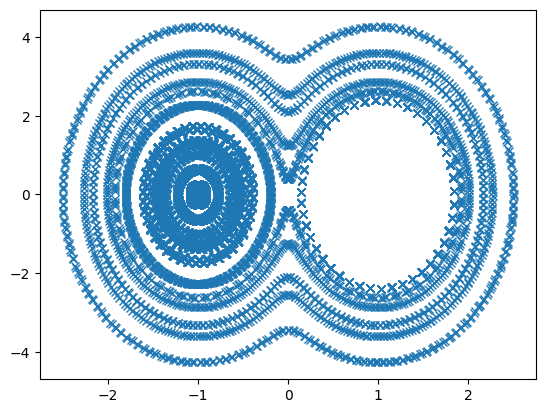

In [3]:
train_test_data = TrainTestData(
    num_samples, expU, expK, T, leap_frog_per_unit, q0, p0
)
samples = train_test_data()
tf.io.write_file("../exps/demo1_train_test_data.txt", tf.io.serialize_tensor(samples))
plt.plot(samples[:, 0], samples[:, 1], "x")
plt.show()

In [4]:
file = tf.io.read_file("../exps/demo1_train_test_data.txt")
train_test_data = tf.io.parse_tensor(file, out_type=tf.float32)
train_data = train_test_data[:num_train, :]
test_data = train_test_data[num_train:, :]
hnn = HamiltonianNeuralNetwork(3, 16)
hnn.build(input_shape=(1, 2))
train_hist, test_hist = hnn.train(15000, 1000, 1e-4, train_data, test_data)
hnn.save_weights("../exps/demo1_hnn.weights.h5")



Training started...
Epoch 100: Train loss 1.4554688930511475, Test loss 8.977803230285645.
Epoch 200: Train loss 0.8438662886619568, Test loss 5.2457356452941895.
Epoch 300: Train loss 0.10068658739328384, Test loss 0.6871615648269653.
Epoch 400: Train loss 0.07012723386287689, Test loss 0.2317904382944107.
Epoch 500: Train loss 0.058935631066560745, Test loss 0.18321585655212402.
Epoch 600: Train loss 0.054542724043130875, Test loss 0.1501777023077011.
Epoch 700: Train loss 0.0446283333003521, Test loss 0.1391230672597885.
Epoch 800: Train loss 0.028971128165721893, Test loss 0.12704907357692719.
Epoch 900: Train loss 0.018670326098799706, Test loss 0.12046795338392258.
Epoch 1000: Train loss 0.014636389911174774, Test loss 0.11216899007558823.
Epoch 1100: Train loss 0.013261569663882256, Test loss 0.10321123152971268.
Epoch 1200: Train loss 0.012464460916817188, Test loss 0.09854668378829956.
Epoch 1300: Train loss 0.011902878060936928, Test loss 0.09883539378643036.
Epoch 1400: Tr

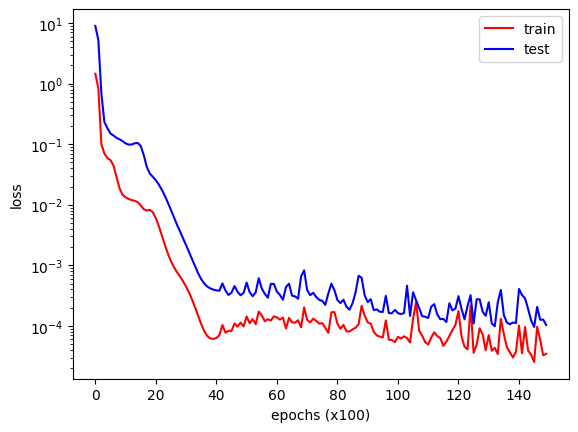

In [5]:
ax, fig = plt.subplots()
fig.plot(train_hist, label="train", color="red")
fig.plot(test_hist, label="test", color="blue")
fig.legend()
fig.set_yscale("log")
fig.set_xlabel("epochs (x100)")
fig.set_ylabel("loss")
plt.show()

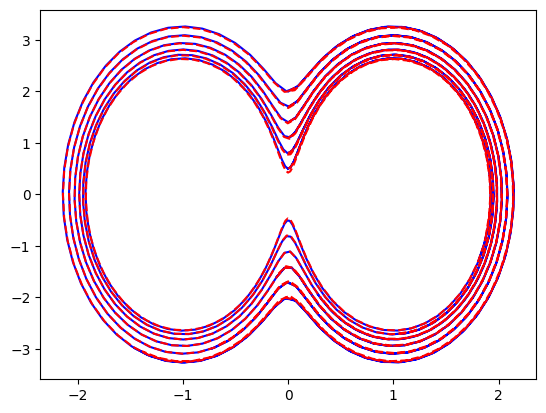

In [6]:
hnn = HamiltonianNeuralNetwork(3, 16)
hnn.build(input_shape=(1, 2))
q0 = tf.constant([0.0])
hnn.load_weights("../exps/demo1_hnn.weights.h5")

fig, ax = plt.subplots()
p_list = tf.linspace(0.5, 2.0, 6)
dt = 1.0 / 20
n_steps = 120
original_hamiltonian = HamiltonianSystem(expU, expK)

for i in range(6):
    p0 = tf.constant([p_list[i].numpy()])
    hist_original = original_hamiltonian.symplectic_integrate(q0, p0, dt, n_steps)
    hist_hnn = hnn.symplectic_integrate(q0, p0, dt, n_steps)
    ax.plot(
        hist_original[:, 0],
        hist_original[:, 1],
        label="Numerical gradients",
        color="blue",
    )
    ax.plot(
        hist_hnn[:, 0],
        hist_hnn[:, 1],
        color="red",
        label="HNNs",
        linestyle="--",
    )
plt.show()

In [7]:
file = tf.io.read_file("../exps/demo1_train_test_data.txt")
train_test_data = tf.io.parse_tensor(file, out_type=tf.float32)
train_data = train_test_data[:num_train, :]
test_data = train_test_data[num_train:, :]
lhnn = LatentHamiltonianNeuralNetwork(3, 16, 4)
lhnn.build(input_shape=(1, 2))
train_hist, test_hist = lhnn.train(15000, 1000, 4e-5, train_data, test_data)
lhnn.save_weights("../exps/demo1_lhnn.weights.h5")

Training started...
Epoch 0: Train loss 2.136197090148926, Test loss 10.837947845458984.
Epoch 100: Train loss 1.5427026748657227, Test loss 9.299839973449707.
Epoch 200: Train loss 1.2905529737472534, Test loss 8.033588409423828.
Epoch 300: Train loss 1.150452733039856, Test loss 6.720771789550781.
Epoch 400: Train loss 1.1042413711547852, Test loss 5.489224910736084.
Epoch 500: Train loss 1.022099494934082, Test loss 4.299102783203125.
Epoch 600: Train loss 0.7989079356193542, Test loss 3.021376848220825.
Epoch 700: Train loss 0.4850270450115204, Test loss 1.8947253227233887.
Epoch 800: Train loss 0.21453434228897095, Test loss 1.1525870561599731.
Epoch 900: Train loss 0.07417631894350052, Test loss 0.7351749539375305.
Epoch 1000: Train loss 0.03196888789534569, Test loss 0.4715381860733032.
Epoch 1100: Train loss 0.022964105010032654, Test loss 0.2873121500015259.
Epoch 1200: Train loss 0.022376876324415207, Test loss 0.1679472178220749.
Epoch 1300: Train loss 0.025936804711818695, 

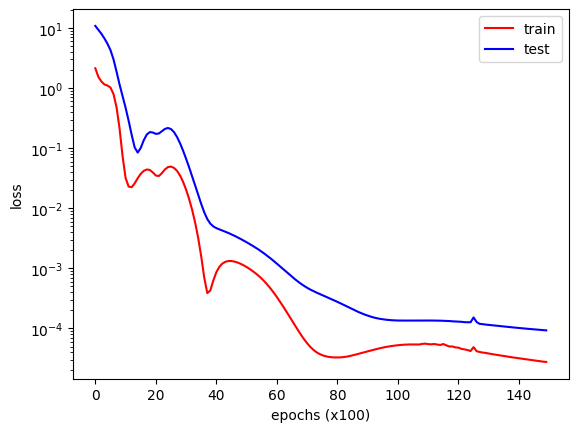

In [8]:
ax, fig = plt.subplots()
fig.plot(train_hist, label="train", color="red")
fig.plot(test_hist, label="test", color="blue")
fig.legend()
fig.set_yscale("log")
fig.set_xlabel("epochs (x100)")
fig.set_ylabel("loss")
plt.show()

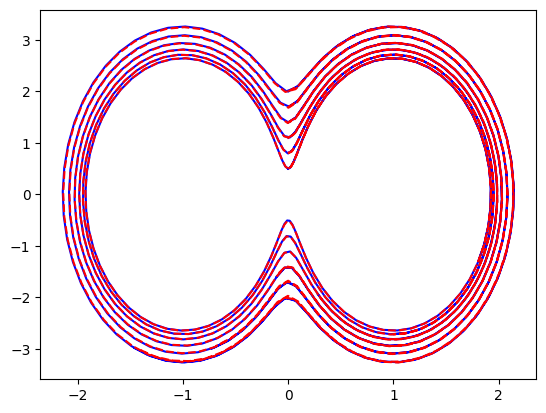

In [9]:
lhnn = LatentHamiltonianNeuralNetwork(3, 16, 4)
lhnn.build(input_shape=(1, 2))
q0 = tf.constant([0.0])
lhnn.load_weights("../exps/demo1_lhnn.weights.h5")

fig, ax = plt.subplots()
p_list = tf.linspace(0.5, 2.0, 6)
dt = 1.0 / 20
n_steps = 120
original_hamiltonian = HamiltonianSystem(expU, expK)

for i in range(6):
    p0 = tf.constant([p_list[i].numpy()])
    hist_original = original_hamiltonian.symplectic_integrate(q0, p0, dt, n_steps)
    hist_lhnn = lhnn.symplectic_integrate(q0, p0, dt, n_steps)
    ax.plot(
        hist_original[:, 0],
        hist_original[:, 1],
        label="Numerical gradients",
        color="blue",
    )
    ax.plot(
        hist_lhnn[:, 0],
        hist_lhnn[:, 1],
        color="red",
        label="HNNs",
        linestyle="--",
    )
plt.show()

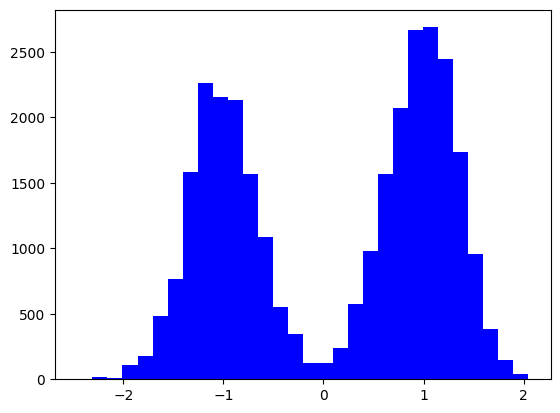

In [ ]:
q0 = tf.constant([[0.0]])
nuts = NoUTurnSampling(num_samples=10000, q0=q0, dt=0.05, lhnn=lhnn)
nuts()
q_hist = tf.concat(nuts.q_hist, axis=0)
plt.hist(q_hist.numpy()[20000:, 0].flatten(), bins=30, color="blue")
plt.show()